<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Modify this cell to add your group name, group number and your names and student IDs

Group: 42

Authors: Yaroslav Nazarov (1282875), Pol Timmer (1007701)

In [1]:
import requests
import io
import numpy as np
import torch

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Training data set

For task 1 of Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains 18.800 binary images of handwritten characters of size (28,28). Each of these images depicts one of 893 different characters from 29 different alphabets. Each image is accompanied by a label that is encoded as an interger $y\in\{0, 1, ..., 892\}$ that indicate the caracter depicted in the image. The following cell provides code that loads the data from hardcoded URLs.

You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 


In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
# Downloading may take a while..
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/tvQmLyY7MhVsADb/download')
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/z234AHrQqx9RVGH/download')

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

train_x shape: (18800, 28, 28)
train_y shape: (18800,)



In [3]:
classes = np.unique(train_y)

In [4]:
from sklearn.model_selection import train_test_split

train_xs, val_xs, train_ys, val_ys = train_test_split(torch.FloatTensor(train_x/1.), train_y, test_size=0.25, stratify=train_y)

In [5]:
print(train_xs.shape)
print(train_ys.shape)
print(val_xs.shape)
print(val_ys.shape)
print(len(np.unique(train_y)))

torch.Size([14100, 28, 28])
(14100,)
torch.Size([4700, 28, 28])
(4700,)
940


In [6]:
print(train_xs)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1., 

### Query data set

For this task you need to use the following query data set. The dataset contains 100 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 

Each test set consists of 1 query image and 5 candidate images. All images are the same size (28x28). The test data is organized in two numpy arrays. One for the query images with shape (100, 1, 28, 28) and another for the candidate imagaes with shape (100, 5, 28, 28). 

The task is to develop a model that enables selecting the image which is depicting the same character as the anchor image out of 5 test images. These test images are declared in the `query_x` numpy array . 

Finally, we plot the first 5 cases in the query dataset. The first column corresponds with the anchor images of each of the 5 cases. All other images are test images from which the task is to recognize the anchor image. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the anchor image. 

In [7]:
query_dataset = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/YGn5gb7unBEuCLB/download")
queries_true = load_numpy_arr_from_url("https://surfdrive.surf.nl/files/index.php/s/0sPeeIFB3W9RPZG/download")

queries, candidates_sets = np.split(query_dataset, [1], axis=1)

print(f"query images have shape: {queries.shape}")
print(f"target sets have shape: {candidates_sets.shape}")
print(f"ground truth: {queries_true.shape}")

query images have shape: (100, 1, 28, 28)
target sets have shape: (100, 5, 28, 28)
ground truth: (100,)


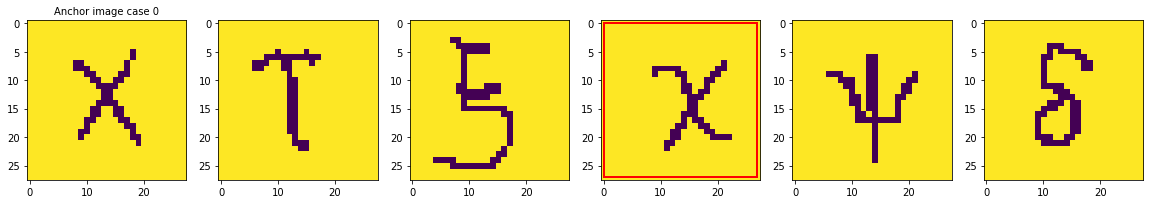

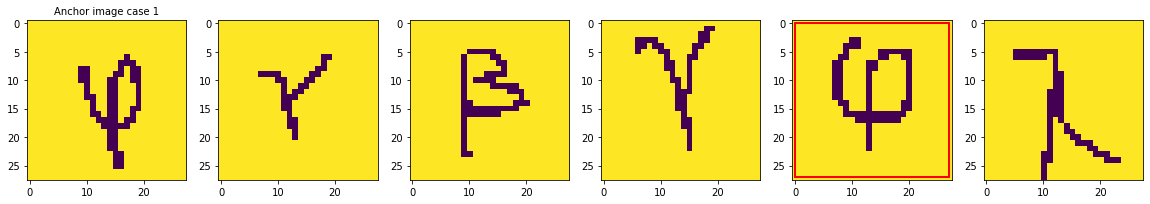

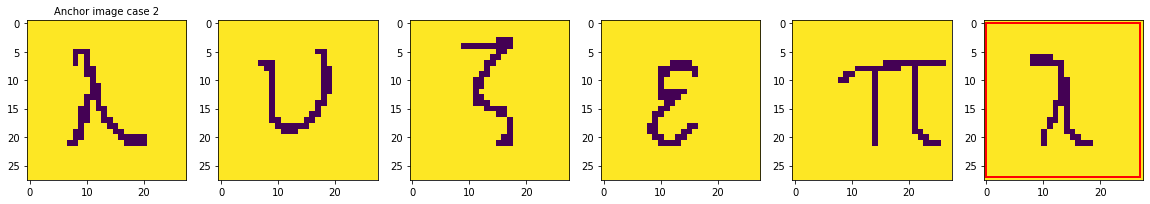

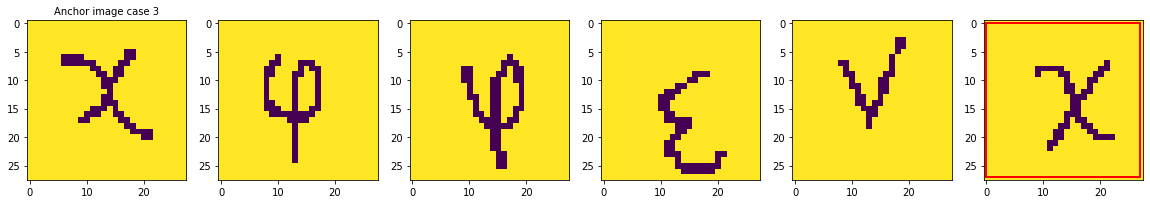

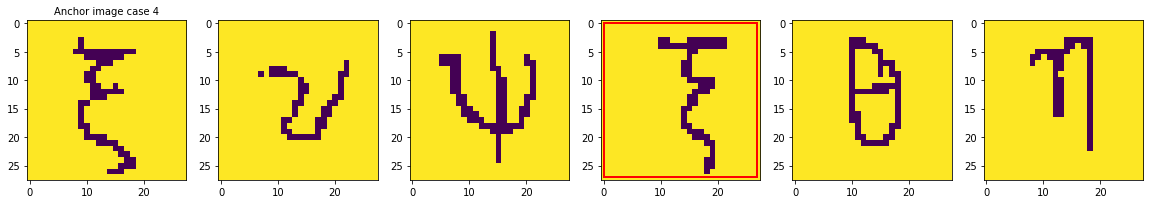

In [8]:
from matplotlib.patches import Rectangle

def plot_case(caseID):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))
    
    # plot anchor image
    axes[0].imshow(queries[caseID, 0])
    axes[0].set_title(f"Anchor image case {caseID}", fontsize=10)
    
    # show all test images images 
    [ax.imshow(candidates_sets[caseID, i]) for i, ax in enumerate(axes[1:])]
    
    
    # Add the patch to the Axes
    axes[queries_true[caseID]].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))
    
    
    
    
# plot the first five samples of the query datset
[plot_case(caseID) for caseID in range(5)] ;

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    first_step = x.view(len(x), 28, 28, 1)
    return first_step.permute(0, 3, 1, 2)


class EmbeddingNet(nn.Module):
    def __init__(self):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()
        
#         self.front_layer = nn.Sequential(
#                 Lambda(preprocess),
#                 nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
#                 nn.ReLU(),
#                 nn.BatchNorm2d(64),
#                 nn.MaxPool2d(2),
#                 nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
#                 nn.ReLU(),
#                 nn.BatchNorm2d(128),
#                 nn.MaxPool2d(2),
#                 nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
#                 nn.ReLU(),
#                 nn.BatchNorm2d(256),
#                 nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
#                 nn.ReLU(),
#                 nn.AdaptiveMaxPool2d(2),
#                 Lambda(lambda x: x.view(x.size(0), -1)),
#                 nn.Linear(2048, 1024),
#                 nn.ReLU(),
#                 nn.Linear(1024, 512),
#                 nn.ReLU(),
#         )

#         self.last_layer = nn.Linear(512, 10)

        self.front_layer = nn.Sequential(
            Lambda(preprocess),
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            Lambda(lambda x: x.reshape(x.size(0), -1))
        )

        self.last_layer = nn.Sequential(
            nn.Linear(self.get_out_size(self.front_layer, (1, 1, 28, 28)), 16),
#             nn.ReLU(),
#             nn.Linear(512, 32),
        )

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x
    
    def get_out_size(self, module, input_dims):
        fake_input = torch.rand(*input_dims, dtype=torch.float)
        output = module(fake_input)
        return output.view(1, -1).size()[1]
    
    def get_embedding(self, x):
        return self.forward(x)

In [11]:
print(EmbeddingNet())

EmbeddingNet(
  (front_layer): Sequential(
    (0): Lambda()
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Lambda()
  )
  (last_layer): Sequential(
    (0): Linear(in_features=1600, out_features=16, bias=True)
  )
)


In [12]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

            
        anchor_idx= triplets[:, 0]  
        positive_idx= triplets[:, 1]  
        negative_idx= triplets[:, 2]  
            
            
        # Finishe the triplet loss funtion  
        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1) #.pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1) #.pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [13]:
from torch.utils.data.sampler import BatchSampler

class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [14]:
train_batch_sampler = BalancedBatchSampler(train_ys, n_classes=893, n_samples=2)
val_batch_sampler = BalancedBatchSampler(val_ys, n_classes=893, n_samples=2)

triplets_train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(train_xs), torch.tensor(train_ys)), batch_sampler=train_batch_sampler)
triplets_val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(val_xs), torch.tensor(val_ys)), batch_sampler=val_batch_sampler)

<ipython-input-14-a1e9c92adeba>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  triplets_train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(train_xs), torch.tensor(train_ys)), batch_sampler=train_batch_sampler)
<ipython-input-14-a1e9c92adeba>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  triplets_val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(val_xs), torch.tensor(val_ys)), batch_sampler=val_batch_sampler)


In [15]:
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

In [16]:
from itertools import combinations

class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            
            if len(label_indices) < 2:
                continue
            
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [17]:
class InformativeTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self, margin):
        super(InformativeTripletSelector, self).__init__()
        self.margin = margin

    def get_triplets(self, embeddings, labels):
        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []
        
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            
            if len(label_indices) < 2:
                continue
            
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = np.array(list(combinations(label_indices, 2)))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()

                hard_negs = np.where(loss_values > 0)[0]
                if len(hard_negs) > 0:
                    triplets += [[anchor_positive[0], anchor_positive[1], np.random.choice(hard_negs)]]

        return torch.LongTensor(np.array(triplets))

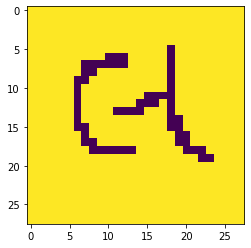

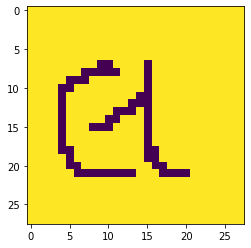

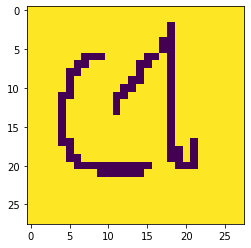

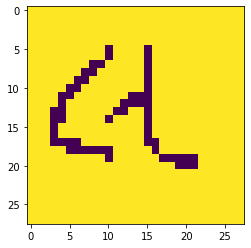

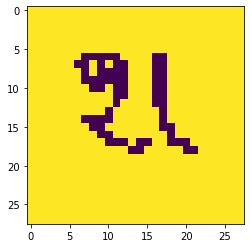

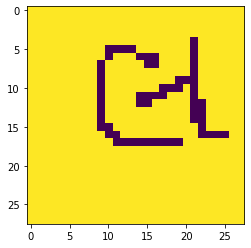

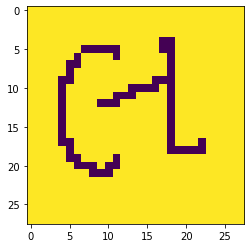

In [18]:
selector = RandomTripletSelector()

for x, y in triplets_train_loader:
    triplet_idxs = selector.get_triplets(None, y)
    anchor_idxs = triplet_idxs[:, 0]  
    positive_idxs = triplet_idxs[:, 1]  
    negative_idxs = triplet_idxs[:, 2] 
    
    plt.figure()
    plt.imshow(x[anchor_idxs[0]])
    

In [19]:
from scipy.spatial.distance import cdist


## The test code bellow will call this function with the following parameters 
## query - the query image (28, 28)
## candidates - numpy array of candidate images, shape (5, 28, 28)
## return - sorted array of the indexes of the images based on the similarty to the query image 
def test_model(query, candidates):
    embedded_candidates = model(torch.as_tensor(candidates, dtype=torch.float).cuda())
    embedded_query = model(torch.as_tensor(query, dtype=torch.float).cuda())
    
    distances = cdist(embedded_query.cpu().detach().numpy(), embedded_candidates.cpu().detach().numpy())
    distances = np.squeeze(distances)
    sorted_indices = np.argsort(distances)

    return sorted_indices

In [20]:
## test top-1
def test_top_1(query, candidates, query_true):
    sorted_indices = test_model(query, candidates)
    return query_true == sorted_indices[0]

## test top-3
def test_top_3(query, candidates, query_true):
    sorted_indices = test_model(query, candidates)
    return np.isin(query_true, sorted_indices[:3])


In [21]:
from tqdm import tqdm
from torchvision.transforms import RandomAffine


class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        
        self.augmentation = RandomAffine(degrees=5, translate=(0.05, 0.05))


    def run_trainer(self):


        for epoch in tqdm(range(self.epochs)):
                 


            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                # print(x)

                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                
                # Transform the input
                input = self.augmentation(input)
                
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss
                 
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters



            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)


                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')
            
            
            top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
            top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

            top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
            print(f"top-1 accuracy: {top_1}")

            top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
            print(f"top-3 accuracy: {top_3}")

In [22]:
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
    
# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=2

# criterion
criterion = TripletLoss(margin,  InformativeTripletSelector(margin))

# optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_val_loader,
                  epochs=10)

# start training
trainer.run_trainer()

 10%|█         | 1/10 [00:04<00:43,  4.79s/it]top-1 accuracy: 0.11
top-3 accuracy: 0.43
EPOCH: 02/10 LOSS: 1.5366 VAL-LOSS: 1.6890
 20%|██        | 2/10 [00:07<00:30,  3.77s/it]top-1 accuracy: 0.08
top-3 accuracy: 0.45
EPOCH: 03/10 LOSS: 1.2408 VAL-LOSS: 0.9540
 30%|███       | 3/10 [00:10<00:24,  3.44s/it]top-1 accuracy: 0.1
top-3 accuracy: 0.44
EPOCH: 04/10 LOSS: 1.2144 VAL-LOSS: 0.7022
 40%|████      | 4/10 [00:13<00:19,  3.28s/it]top-1 accuracy: 0.09
top-3 accuracy: 0.42
EPOCH: 05/10 LOSS: 1.1442 VAL-LOSS: 0.7193
 50%|█████     | 5/10 [00:16<00:16,  3.20s/it]top-1 accuracy: 0.05
top-3 accuracy: 0.45
EPOCH: 06/10 LOSS: 1.0642 VAL-LOSS: 0.7783
 60%|██████    | 6/10 [00:20<00:12,  3.15s/it]top-1 accuracy: 0.02
top-3 accuracy: 0.46
EPOCH: 07/10 LOSS: 1.0624 VAL-LOSS: 0.9470
 70%|███████   | 7/10 [00:23<00:09,  3.12s/it]top-1 accuracy: 0.02
top-3 accuracy: 0.4
EPOCH: 08/10 LOSS: 1.1640 VAL-LOSS: 1.0016
 80%|████████  | 8/10 [00:26<00:06,  3.09s/it]top-1 accuracy: 0.02
top-3 accuracy: 0.

In [23]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [24]:
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_xs, train_ys), batch_size=256)
val_loader = torch.utils.data.DataLoader(ConcatDataset(val_xs, val_ys), batch_size=256)

def extract_embeddings(dataloader, model):
    
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 16))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(train_loader, model)
val_embeddings, val_labels = extract_embeddings(val_loader, model)

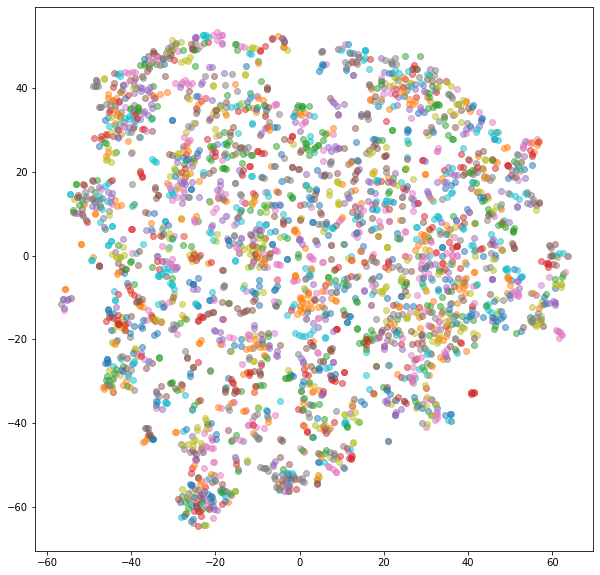

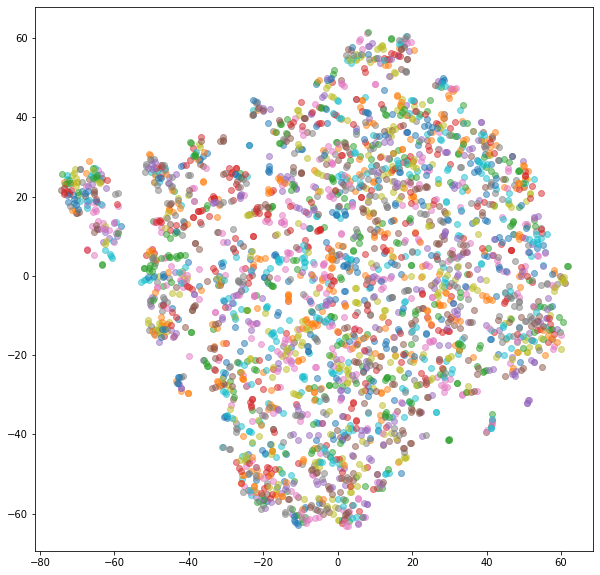

In [25]:
from sklearn.manifold import TSNE
def plot_tsne_embeddings(embeddings, targets, xlim=None, ylim=None):
    
    
    # The first 3000 embeddings and targets
    embeddings= embeddings[:3000]
    targets= targets[:3000]

    # Using Tsne to for dimension reduction 
    tsne = TSNE(n_components=2)
    embeddings = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    # plt.legend(classes)

plot_tsne_embeddings(train_embeddings, train_labels)
plot_tsne_embeddings(val_embeddings, val_labels)

In [26]:
from scipy.spatial.distance import cdist


## The test code bellow will call this function with the following parameters 
## query - the query image (28, 28)
## candidates - numpy array of candidate images, shape (5, 28, 28)
## return - sorted array of the indexes of the images based on the similarty to the query image 
def test_model(query, candidates):
    embedded_candidates = model(torch.as_tensor(candidates, dtype=torch.float).cuda())
    embedded_query = model(torch.as_tensor(query, dtype=torch.float).cuda())
    
    distances = cdist(embedded_query.cpu().detach().numpy(), embedded_candidates.cpu().detach().numpy())
    distances = np.squeeze(distances)
    sorted_indices = np.argsort(distances) + 1

    return sorted_indices

In [27]:
## test top-1
def test_top_1(query, candidates, query_true):
    sorted_indices = test_model(query, candidates)
    return query_true == sorted_indices[0]

## test top-3
def test_top_3(query, candidates, query_true):
    sorted_indices = test_model(query, candidates)
    return np.isin(query_true, sorted_indices[:3])

top_1_res = np.array([test_top_1(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])
top_3_res = np.array([test_top_3(a, b, c) for (a, b, c) in zip(queries, candidates_sets, queries_true)])

top_1 = np.count_nonzero(top_1_res) / queries.shape[0]
print(f"top-1 accuracy: {top_1}")

top_3 = np.count_nonzero(top_3_res) / queries.shape[0]
print(f"top-3 accuracy: {top_3}")


top-1 accuracy: 0.74
top-3 accuracy: 0.98
